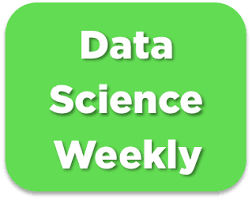

# Challenge : predict conversions 🏆🏆

# Import libraries

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

from IPython.display import display

# Read file with labels

In [4]:
data = pd.read_csv('/content/conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (59203, 6)


In [5]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0.0
1,UK,21,1,Ads,3,0.0
2,Germany,20,0,Seo,14,1.0
3,US,23,1,Seo,3,0.0
4,US,28,1,Direct,3,0.0


# Explore dataset

#Part 1 :  EDA

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59203 entries, 0 to 59202
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   country              59203 non-null  object 
 1   age                  59203 non-null  int64  
 2   new_user             59203 non-null  int64  
 3   source               59203 non-null  object 
 4   total_pages_visited  59203 non-null  int64  
 5   converted            59202 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 2.7+ MB


In [9]:
data.describe(include='all')

,country,age,new_user,source,total_pages_visited,converted
count,59203,59203.000000,59203.000000,59203,59203.000000,59202.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,33371,NaN,NaN,28834,NaN,NaN
mean,NaN,30.595578,0.685438,NaN,4.880580,0.032246
std,NaN,8.244437,0.464345,NaN,3.355812,0.176653
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


In [13]:
# View missing values
data.isnull().sum() / len(data) * 100

,0
country,0.000000
age,0.000000
new_user,0.000000
source,0.000000
total_pages_visited,0.000000
converted,0.001689


In [18]:
# View Duplicates
print(f"Percentage of duplicated rows is {(data.duplicated().sum() /  len (data) * 100).round(2)}%")

Percentage of duplicated rows is 83.73%


##Data Distribution

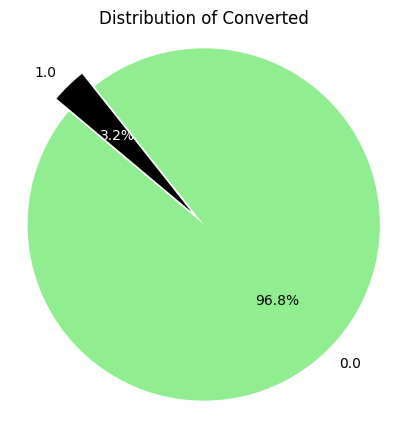

In [31]:
# Target distribution
converted_counts = data['converted'].value_counts()

plt.figure(figsize=(5, 5), facecolor = "white")
patches, texts, autotexts  = plt.pie(converted_counts, labels=converted_counts.index, autopct='%1.1f%%', startangle=140, colors = ["lightgreen", "black"], explode=(0.1, 0))
autotexts[1].set_color('white')
plt.title('Distribution of Converted')
plt.axis('equal')
plt.show()


- The pie chart above indicates that the target disribution is unbalanced.
- We have no missing values and there are 83.73 % duplicate rows. There are 59203 rows and  6  columns in the dataset.
- We seem to have outliers in 'age' this will be handled later on.




##Categorical distribution

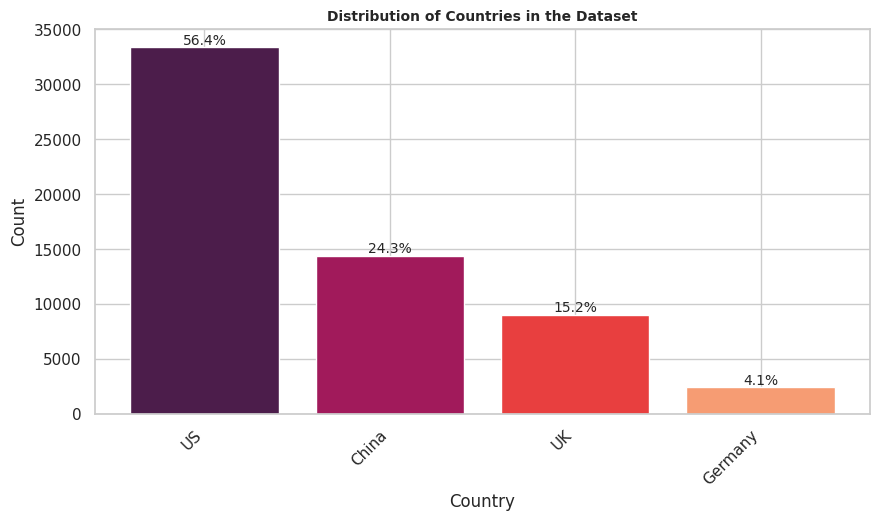

In [78]:
# Country Distribution

sns.set_theme(style="whitegrid")

# Compute sorted country counts
country_counts = data['country'].value_counts()

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Bar plot
bars = ax.bar(country_counts.index, country_counts.values, color=sns.color_palette('rocket', len(country_counts)))

# Add percentage labels
ax.bar_label(bars, labels=[f"{(count / len(data)) * 100:.1f}%" for count in country_counts.values], fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Countries in the Dataset', fontsize=10, fontweight='bold')
plt.xlabel('Country', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()

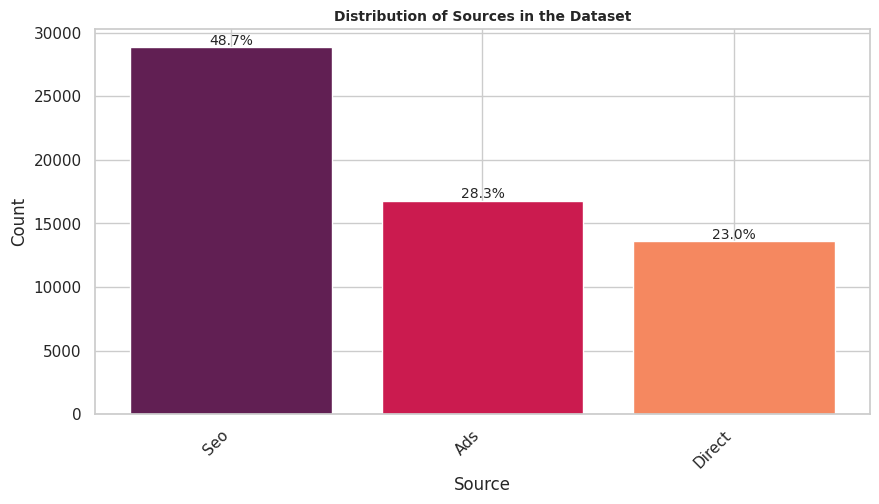

In [77]:
# Source Distribution
sns.set_theme(style="whitegrid")

source_counts = data['source'].value_counts()
# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Bar plot
bars = ax.bar(source_counts.index, source_counts.values, color=sns.color_palette('rocket', len(source_counts)))

ax.bar_label(bars, labels=[f"{(count / len(data)) * 100:.1f}%" for count in source_counts.values], fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Sources in the Dataset', fontsize=10, fontweight='bold')
plt.xlabel('Source', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Show plot
plt.show()

##Numerical distribution

In [71]:
# Total_pages_visited Distribution
total_pages = data['total_pages_visited'].value_counts().reset_index()
total_pages.columns = ['Total Pages Visited', 'Count']

fig = px.bar(total_pages,
             x='Total Pages Visited',
             y='Count',
             color='Count',
             color_continuous_scale='greens',
             title='Distribution of Total Pages Visited in the Dataset')

fig.update_layout(xaxis_title='Total Pages Visited',
                  yaxis_title='Count',
                  xaxis_tickangle=-45)

fig.show(renderer='colab')

In [70]:
# Age distribution
ages = data['age'].value_counts().reset_index()
ages.columns = ['age', 'Count']

fig = px.bar(ages,
             x='age',
             y='Count',
             color='Count',
             color_continuous_scale='greens',
             title='Distribution of Ages in the Dataset')

fig.update_layout(xaxis_title='Ages',
                  yaxis_title='Count',
                  xaxis_tickangle=-45)

fig.show(renderer='colab')

##Outliers

In [97]:
# Find Q1, Q3 and IQR
Q1 = data['age'].quantile(0.25)
Q3 = data['age'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = (data['age'] < Q1 - 1.5 * IQR) | (data['age'] > Q3 + 1.5 *IQR)

In [98]:
# Remove outliers
data_train_cleaned = data[~outliers]
print('Data shape:', data_train_cleaned.shape)

Data shape: (58928, 6)


In [107]:
fig = px.box(data_train_cleaned.melt(value_vars=columns_to_check,
                                     var_name='Feature',
                                     value_name='Value'),
             y='Value',
             color='Feature',
             facet_col='Feature',
             title='Age')

fig.update_layout(height=400, width=400, showlegend=False)
fig.show(renderer='colab')

# Create model

In [7]:
# The dataset is quite big let's create a sample of the dataset before making any visualizations
data_sample = data.sample(10000)

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [ ]:
features_list = ['total_pages_visited']
numeric_indices = [0]
categorical_indices = []
target_variable = 'converted'

In [ ]:
X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['total_pages_visited'], dtype='object')



In [ ]:
# Divide dataset Train set & Test set
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



## Training pipeline

In [ ]:
# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")

featureencoder = StandardScaler()
X_train = featureencoder.fit_transform(X_train)
print("...Done")
print(X_train[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.26070136]
 [ 0.93728655]
 [-0.85969532]
 [-0.56019834]
 [-0.26070136]]


In [ ]:
# Train model
print("Train model...")
classifier = LogisticRegression() #
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [ ]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



## Test pipeline

In [ ]:
# Use X_test, and the same preprocessings as in training pipeline,
# but call "transform()" instead of "fit_transform" methods (see example below)

print("Encoding categorical features and standardizing numerical features...")

X_test = featureencoder.transform(X_test)
print("...Done")
print(X_test[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 0.63778957]
 [ 0.03879562]
 [-0.26070136]
 [-0.26070136]
 [ 0.63778957]]


In [ ]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



## Performance assessment

In [ ]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.6938517686692869
f1-score on test set :  0.7060240963855422


In [ ]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[246817   1082]
 [  3280   4943]]

Confusion matrix on test set : 
[[27384   117]
 [  371   586]]



**Our baseline model reaches a f1-score of almost 70%. Now, feel free to refine your model and try to beat this score ! 🚀🚀**

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [ ]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifier.fit(X,Y)

LogisticRegression()

In [ ]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features
# used by your best classifier)
features_list = ['total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to arrays before using scikit-learn
print("Convert pandas DataFrames to arrays...")
X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels[0:5,:])

Prediction set (without labels) : (31620, 5)
Convert pandas DataFrames to arrays...
...Done
[[16]
 [ 5]
 [ 1]
 [ 6]
 [ 3]]


In [ ]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = featureencoder.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 3.33326238]
 [ 0.03879562]
 [-1.15919229]
 [ 0.3382926 ]
 [-0.56019834]]


In [ ]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_EXAMPLE.csv', index=False)


## Analyzing the coefficients and interpreting the result
**In this template, we just trained a model with only one feature (total_pages_visited), so there's no analysis to be done about the feature importance 🤔**

**Once you've included more features in your model, please take some time to analyze the model's parameters and try to find some lever for action to improve the newsletter's conversion rate 😎😎**